* Compare minimum salinity value, location, fresh water amount between ferry observation, nowcast and new model results.

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,geo_tools,tidetools)
from datetime import datetime, timedelta
from glob import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import netCDF4 as nc
import numpy as np
import seaborn as sns
import os
import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
import sys
sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import salinity3_copy

In [3]:
paths = {'nowcast': '/results/SalishSea/nowcast/',
        'longerresult': '/data/jieliu/MEOPAR/river-treatment/14days_norefraserxml/',
        'widenresult': '/data/jieliu/MEOPAR/river-treatment/14nor_NWSmoorerunMoreSubdomain/'}

In [4]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd,results_home):
    k=0
    values =0
    valuess=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    
    x1, j1 = geo_tools.find_closest_model_point(lon11[q],lat11[q],X,Y,land_mask=bathy.mask)
    if results_home == paths['nowcast'] or results_home == paths['longerresult']:
        x1 =x1;
        j1 = j1
    elif results_home == paths['widenresult']: ## this is subdomain
        x1 = x1-349;
        j1 = j1 - 200
    for i in np.arange(x1-1,x1+2):
         for j in np.arange(j1-1,j1+2):
            dist[k]=geo_tools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            values=values+value_3rd[k]
            valuess=valuess+value_4rd[k]
            k+=1
            
    return values, valuess, weights

In [5]:
def salinity_fxn_norm(saline, run_date, results_home, run_lower, run_upper):
    """The significance of this function was to return longitude,
       latitude, salinity values for observations, 1.5m of 3rd & 4rd, 
       3m average of 3rd & 4rd model result and the time selection for 
       saline_nemo_3rd or 4rd is in the middle """

    a=saline['ferryData']
    b=a['data']
    dataa = b[0,0]
    time=dataa['matlabtime'][0,0]
    lonn=dataa['Longitude'][0,0]
    latt=dataa['Latitude'][0,0]
    salinity=dataa['Practical_Salinity'][0,0]   
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        
        if(python_datetime >= run_lower) &(python_datetime <= run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]
    date_str = run_date.strftime('%d-%b-%Y')
    if results_home == paths['nowcast']:
        bathyold, X, Y = salinity3_copy.get_SS2_bathy_data()   
    elif results_home ==paths['longerresult']:
        bathynew5, X, Y = salinity3_copy.get_SS5_bathy_data()
    else:
        bathynew6, X, Y = salinity3_copy.get_SS6_bathy_data()

    if results_home == paths['nowcast'] or results_home ==paths['longerresult']:
    ## if nowcast of bathy5, the result file is whole domain  
        filepath_name = salinity3_copy.date(run_date.year,run_date.month, run_date.day,\
        run_date.day,run_date.day, results_home,'1h','grid_T') 
        tracers=nc.Dataset(filepath_name[0])
    elif results_home ==paths['widenresult']:
        tracers=nc.Dataset(paths['widenresult']+'1hplume06160629smooLargestgridT.nc')
        
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']

    matrix=np.zeros([len(lon11),9])
    values=np.zeros([len(lon11),1])
    valuess=np.zeros([len(lon11),1])
    value_mean_3rd_hour=np.zeros([len(lon11),1])
    value_mean_4rd_hour=np.zeros([len(lon11),1])
    if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 or\
        run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==16 or run_lower.hour ==21:
        if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 : 
            saline_nemo_3rd = saline_nemo[run_lower.hour +1,1, 0:898, 0:398] 
            saline_nemo_4rd = saline_nemo[run_upper.hour ,1, 0:898, 0:398]
        elif run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==16 or run_lower.hour ==21:
            saline_nemo_3rd = saline_nemo[run_lower.hour +1,1, 0:898, 0:398] 
            saline_nemo_4rd = saline_nemo[run_upper.hour ,1, 0:898, 0:398]
        for q in np.arange(0,len(lon11)):
            if (~np.isnan(lon11[q])) and (~np.isnan(lat11[q])):
                if results_home == paths['nowcast']:
                    #print(lon11[q],lat11[q])
                    values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                                 bathyold, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd, results_home)
                    value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

                elif results_home ==paths['longerresult']:
                    values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                                 bathynew5, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd,results_home)
                    value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

                elif results_home ==paths['widenresult']:
                    values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                                 bathynew6, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd,results_home)
                    value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

        #print(value_mean_3rd_hour.shape,value_mean_3rd_hour)
    else:
        value_mean_3rd_hour[:] = np.nan
        value_mean_4rd_hour[:] = np.nan     
    #elif results_home ==paths['widenresult']: ## if subdomain file
        #date_str = run_date.strftime('%d-%b-%Y') 
        #value_mean_3rd_hour, value_mean_4rd_hour= salinity_along_track_bathy6\
        #(results_home,run_date,run_lower,run_upper,lon11,lat11,X,Y,bathynew6)

    return lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour, \
    salinity11, salinity1_2_4, date_str

In [6]:
def salinity_along_track_bathy6(results_home,run_date,run_lower,run_upper,lon11,lat11,X,Y,bathynew6):
    """Only for subdomain to track the salinity and location of model results along route"""
    tracers=nc.Dataset(paths['widenresult']+'1hplume06160629smooLargestgridT.nc')
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']
    
    matrix=np.zeros([len(lon11),9])
    values=np.zeros([len(lon11),1])
    valuess=np.zeros([len(lon11),1])
    value_mean_3rd_hour=np.zeros([len(lon11),1])
    value_mean_4rd_hour=np.zeros([len(lon11),1])
    if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 or\
        run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==16 or run_lower.hour ==21:
        if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 : 
            saline_nemo_3rd = saline_nemo[run_lower.hour +1 + (run_date.day-16)*24,1] 
            saline_nemo_4rd = saline_nemo[run_upper.hour + (run_date.day-16)*24,1]
        elif run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==16 or run_lower.hour ==21:
            saline_nemo_3rd = saline_nemo[run_lower.hour +1 + (run_date.day-16)*24,1] 
            saline_nemo_4rd = saline_nemo[run_upper.hour + (run_date.day-16)*24,1]
        for q in np.arange(0,len(lon11)):
            if (~np.isnan(lon11[q])) and (~np.isnan(lat11[q])) and (lon11[q]>-123.6):
                values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                            bathynew6, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd,results_home)
                value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
                value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])
            if lon11[q]<=-123.6: ## if 0 then set to nan
                value_mean_3rd_hour[q] =np.nan
    else:
        value_mean_3rd_hour[:] = np.nan
        value_mean_4rd_hour[:] = np.nan   
    return value_mean_3rd_hour, value_mean_4rd_hour

In [7]:
def min_salinity_test(days,results_home):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    sal_min_obs = []; lon_obs = [];sal_min_15 = [];lon_15=[]; fresh_obs = [];fresh_15 = []
    for day in days:
        for i in np.arange(24):
            if i < 12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201506%s.mat' %(day))
            elif i>=12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201506%s.mat' %(day+1))
            ## read in run_date, run_lower and run_upper for each trip case.
            run_date = datetime.datetime(2015,6,day+1)
            if i == 0 or i==14 or i==16 or i==21:
                run_lower = run_date.replace(hour = i, minute = 45)
                if i ==14:
                    run_upper = run_lower.replace(hour = i+2)
                if i==21:
                    run_upper = run_date.replace(day = day+2,hour = 0, minute = 45)
                else:
                    run_upper = run_lower.replace(hour = i +3, minute = 15)
            if i ==3 or i==5 or i==19:
                run_lower = run_date.replace(hour = i, minute = 15)
                run_upper = run_lower.replace(hour = i+2, minute = 45)
            ##extract values from ferry route   
            if i == 0 or i==14 or i==16 or i==21 or i ==3 or i==5 or i==19:
                lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                salinity11, salinity1_2_4, date_str = salinity_fxn_norm\
                (saline, run_date, results_home,run_lower,run_upper)
            ## find min salinity value and location along ferry route and freshwater amount
                salinity_min_obs, lon_min_obs, salinity_min_15,lon_min_15 =find_min_value_location\
                (run_date, results_home, saline, run_lower, run_upper,lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_3rd_deep, value_mean_4rd_deep, \
                salinity11, salinity1_2_4, date_str)
                fresh_obsInd, fresh_15Ind = freshwater(results_home,lon_model, lat_model, lon1_model, lat1_model,salinity1_2_4,value_mean_3rd_deep)
            else: 
                salinity_min_obs= np.nan;lon_min_obs=np.nan;salinity_min_15=np.nan;lon_min_15=np.nan;
                fresh_obsInd = np.nan; fresh_15Ind= np.nan
            ## append the values to a list
            sal_min_obs.append(salinity_min_obs);
            lon_obs.append(float(lon_min_obs));
            sal_min_15.append(salinity_min_15);
            lon_15.append(float(lon_min_15));
            fresh_obs.append(fresh_obsInd);
            fresh_15.append(fresh_15Ind)

    return sal_min_obs, lon_obs, sal_min_15,lon_15, fresh_obs,fresh_15

In [8]:
def find_min_value_location(run_date, results_home, saline, run_lower, run_upper,lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour, \
    salinity11, salinity1_2_4,date_str):
    """This function was made to find out the minimum salinity value
       and longitude for observation and nowcasts(1.5m and 3m ave) or 
       for observation and new results(1.5m and 3m ave)."""
    
    ##For observation
    if len(salinity1_2_4) ==0:
        salinity_min_obs = np.nan
        lon_min_obs=np.nan
    else:
        salinity_min_obs = np.nanmin(salinity1_2_4)
        ind_obs = np.nanargmin(salinity1_2_4)
        lon_min_obs = lon1_2_4[ind_obs]
    
    ## For nowcast or new model result with 1.5m depth for 3rd model time 
    ## no length or all nan or all 0, then set to nan
    if (len(value_mean_3rd_hour) ==0) or (np.nansum(value_mean_3rd_hour) ==np.nan) or (np.nansum(value_mean_3rd_hour) ==0):
        
        salinity_min_15 = np.nan
        lon_min_15=np.nan

    else:
        salinity_min_15 = np.nanmin(value_mean_3rd_hour)## some cases when part of them are 0
        ## since it is subdomain
        ind_15 = np.nanargmin(value_mean_3rd_hour)
        lon_min_15 = lon11[ind_15]
    
    return salinity_min_obs, lon_min_obs, salinity_min_15,lon_min_15

In [9]:
def freshwater(results_home,lon11, lat11, lon1_2_4, lat1_2_4,salinity1_2_4,value_mean_3rd_hour):
    salinity1_2_4[np.isnan(salinity1_2_4)] = 30 ##set nan to 30 psu for observation
    #print(len(lon1_2_4))
    if len(lon1_2_4) != 0:
        obs_Sdx = np.zeros(len(lon1_2_4)-1) ## index from 0 to 718
        mod_new_15Sdx = np.zeros(len(lon11)-1)

        length_obs = np.arange(len(lon1_2_4)-1)
        length_mod = np.arange(len(lon11) - 1)
        ## For observation:
        for i in length_obs:
            obs_Sdx[i] = (30 - salinity1_2_4[:,0][i]) * np.abs(np.diff(lon1_2_4[:,0])[i]) * \
            111000 * np.cos(np.pi*lat1_2_4[i]/180) #discrete outcome by multiplying 
        obs_total_integral = np.cumsum(obs_Sdx)
        max_amount_obs = max(obs_total_integral)
        ## For model results:    
        for j in length_mod:
            mod_new_15Sdx[j] = (30 - value_mean_3rd_hour[:,0][j]) * np.abs(np.diff(lon11[:,0])[j]) * \
            111000 * np.cos(np.pi*lat11[j]/180)  
        mod_total_new_15integral = np.cumsum(mod_new_15Sdx)
        ## Find max for 1.5m 
        max_mod_new15 = max(mod_total_new_15integral)
    else:
        max_amount_obs = np.nan
        max_mod_new15 = np.nan

    return max_amount_obs, max_mod_new15

In [10]:
## for nowcasts
days = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sal_min_obs,lon_obs,sal_now,lon_now,fre_obs,fre_now= min_salinity_test(days,paths['nowcast'])

In [11]:
## for bathy5
days = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sal_min_obs,lon_obs,sal_bathy5,lon_bathy5,fre_obs,fre_15= min_salinity_test(days,paths['longerresult'])

In [13]:
## for bathy6
days = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sal_min_obs,lon_obs,sal_bathy6,lon_bathy6,fre_obs,fre_16= min_salinity_test(days,paths['widenresult'])

In [14]:
## value & loc
sal_obs_ave = []
sal_nowcast_ave = []
sal_bathy5_ave = []
sal_bathy6_ave = [];
for i in np.arange(0,336,24):
    sal_obs_ave.append(np.nanmean(sal_min_obs[i:i+24]))
    sal_nowcast_ave.append(np.nanmean(sal_now[i:i+24]))
    sal_bathy5_ave.append(np.nanmean(sal_bathy5[i:i+24]))
    sal_bathy6_ave.append(np.nanmean(sal_bathy6[i:i+24]))
for i in np.arange(3,5):
    sal_obs_ave[i] = np.nan ## June 19,20 no data actually
    sal_nowcast_ave[i] = np.nan
    sal_bathy5_ave[i]=np.nan
    sal_bathy6_ave[i] = np.nan

In [15]:
## location
sal_obs_aveloc = []
sal_nowcast_aveloc = []
sal_bathy5_aveloc = []
sal_bathy6_aveloc = []
for i in np.arange(0,336,24):
    sal_obs_aveloc.append(np.nanmean(lon_obs[i:i+24]))
    sal_nowcast_aveloc.append(np.nanmean(lon_now[i:i+24]))
    sal_bathy5_aveloc.append(np.nanmean(lon_bathy5[i:i+24]))
    sal_bathy6_aveloc.append(np.nanmean(lon_bathy6[i:i+24]))
for i in np.arange(3,5):
    sal_obs_aveloc[i] = np.nan ## June 19,20 no data actually
    sal_nowcast_aveloc[i] = np.nan
    sal_bathy5_aveloc[i]=np.nan
    sal_bathy6_aveloc[i] = np.nan

In [16]:
## freshwater
fresh_obs_ave = []
fresh_nowcast_ave = []
fresh_bathy5_ave = []
fresh_bathy6_ave = [];
for i in np.arange(0,336,24):
    fresh_obs_ave.append(np.nanmean(fre_obs[i:i+24]))
    fresh_nowcast_ave.append(np.nanmean(fre_now[i:i+24]))
    fresh_bathy5_ave.append(np.nanmean(fre_15[i:i+24]))
    fresh_bathy6_ave.append(np.nanmean(fre_16[i:i+24]))
for i in np.arange(3,5):
    fresh_obs_ave[i] = np.nan ## June 19,20 no data actually
    fresh_nowcast_ave[i] = np.nan
    fresh_bathy5_ave[i]=np.nan
    fresh_bathy6_ave[i] = np.nan

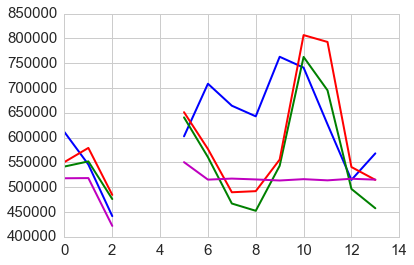

In [27]:
plt.plot(fresh_obs_ave,'b')
plt.plot(fresh_nowcast_ave,'g')
plt.plot(fresh_bathy5_ave,'r')
plt.plot(fresh_bathy6_ave,'m')

In [31]:
len(t)

14

-0.1 14.6 0.0 1.0 0.8


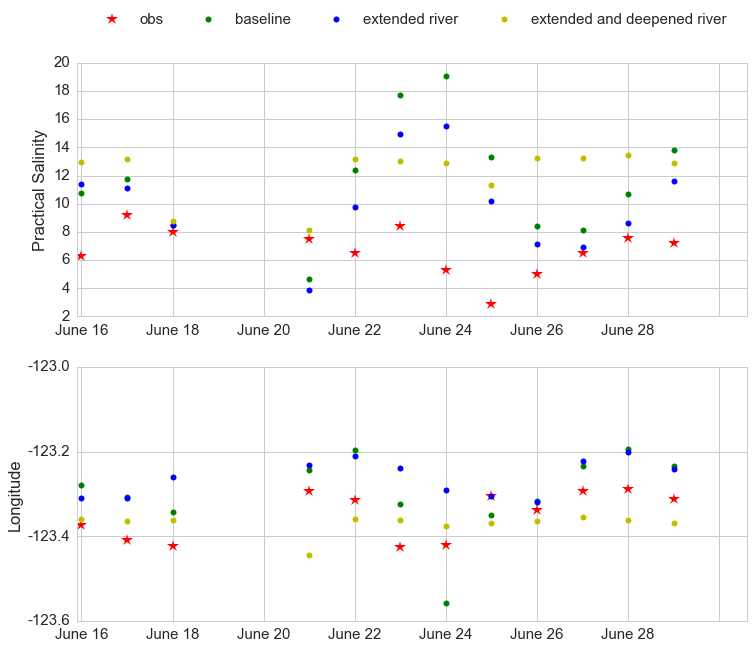

In [49]:
## value
t = np.arange(len(sal_obs_ave))
size = 12
fig,axs = plt.subplots(2,1,figsize = (12,10))
ax =axs[0]
ax.plot(t,sal_obs_ave,'r*',label = 'obs', markersize = size)
ax.plot(t,sal_nowcast_ave,'g.',label = 'baseline', markersize = size)
ax.plot(t,sal_bathy5_ave,'b.',label ='extended river', markersize = size)
ax.plot(t,sal_bathy6_ave,'y.',label = 'extended and deepened river', markersize = size)
ax.set_ylabel('Practical Salinity')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=True)
xticks, xticklabels = plt.xticks()
xmin = (30*xticks[0] - xticks[1])/2.
xmax = (30*xticks[-1] - xticks[-2])/2.
print(xmin,xmax,xticks[0],xticks[-1],xticks[-2])
x = range(0,16,2)
## location
ax = axs[1]
ax.plot(t,sal_obs_aveloc,'r*', markersize = size)
ax.plot(t,sal_nowcast_aveloc,'g.', markersize = size)
ax.plot(t,sal_bathy5_aveloc,'b.', markersize = size)
ax.plot(t,sal_bathy6_aveloc,'y.', markersize = size)
ax.set_yticks([-123., -123.2,-123.4,-123.6])
ax.set_yticklabels([-123., -123.2,-123.4,-123.6])
ax.set_ylabel('Longitude')
for ax in axs:
    ax.set_xlim(xmin, xmax)
    ax.set_xticks(x)
    ax.set_xticklabels( ['June 16','June 18','June 20','June 22','June 24','June 26','June 28'] )

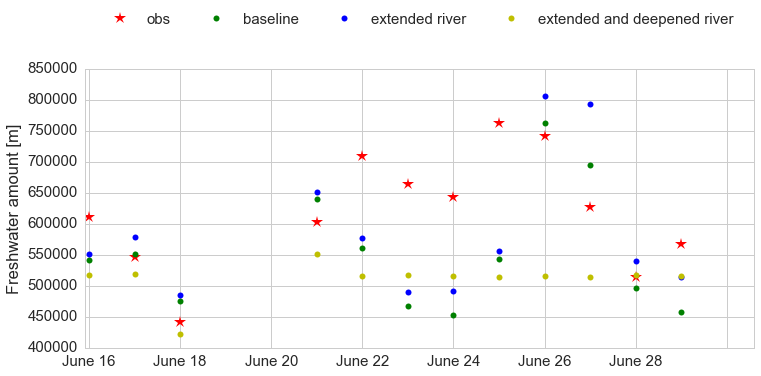

In [57]:
fig,axs = plt.subplots(1,1,figsize = (12,5))

axs.plot(t,fresh_obs_ave,'r*',label = 'obs', markersize = size)
axs.plot(t,fresh_nowcast_ave,'g.',label = 'baseline', markersize = size)
axs.plot(t,fresh_bathy5_ave,'b.',label ='extended river', markersize = size)
axs.plot(t,fresh_bathy6_ave,'y.',label = 'extended and deepened river', markersize = size)
axs.set_ylabel('Practical Salinity')
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=True)
xticks, xticklabels = plt.xticks()
xmin = -0.1
xmax = xticks[-1]+0.6
axs.set_ylabel('Freshwater amount [m]')
x = range(0,16,2)
axs.set_xlim(xmin, xmax)
axs.set_xticks(x)
axs.set_xticklabels( ['June 16','June 18','June 20','June 22','June 24','June 26','June 28'] )

In [15]:
## difference of location between model result and obs
diff_now = []
diff_bathy5 = []
diff_bathy6= []
for i in np.arange(len(sal_bathy5_aveloc)):
    diff_now.append(np.abs(sal_obs_aveloc[i]-sal_nowcast_aveloc[i]))
    diff_bathy5.append(np.abs(sal_obs_aveloc[i]-sal_bathy5_aveloc[i]))
    diff_bathy6.append(np.abs(sal_obs_aveloc[i]-sal_bathy6_aveloc[i]))

In [16]:
np.nanmean(diff_now)*111000*np.cos(50*np.pi/180)

5826.2623738289576

In [17]:
np.nanmean(diff_bathy5)*111000*np.cos(50*np.pi/180)

6274.3903668204712

In [18]:
np.nanmean(diff_bathy6)*111000*np.cos(50*np.pi/180)

4051.2716359026363

* Usually, model result is saltier than observation from plots of minimum salinity and freshwater amount. Location of plume is close to Vancouver compared with observation, which indicates discrepency of plume position. Our plume could not propagate further away cross the strait, other external forcing, such as wind should be taken into consideration. What about comparing wind in the model with observed wind?? 